In [2]:
%matplotlib inline
import matplotlib.image as mpimg
from torch import nn
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from torchinfo import summary
import torch
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("Goodluck")

device = torch.device(device)

# Loading dataset

In [4]:
# Loading dataset
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data
def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)
        gt_img_3c[:, :, 0] = gt_img8
        gt_img_3c[:, :, 1] = gt_img8
        gt_img_3c[:, :, 2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg
def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if is_2d:
                im_patch = im[j : j + w, i : i + h]
            else:
                im_patch = im[j : j + w, i : i + h, :]
            list_patches.append(im_patch)
    return list_patches

root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(400, len(files))  # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


# Patching

In [5]:
PATCH_SIZE = 400

img_patches = [img_crop(imgs[i], PATCH_SIZE, PATCH_SIZE) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], PATCH_SIZE, PATCH_SIZE) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray(
    [
        img_patches[i][j]
        for i in range(len(img_patches))
        for j in range(len(img_patches[i]))
    ]
)
gt_patches = np.asarray(
    [
        gt_patches[i][j]
        for i in range(len(gt_patches))
        for j in range(len(gt_patches[i]))
    ]
)

img_patches.shape

(100, 400, 400, 3)

# Trying a simple FCN

In [107]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        # Input shape: (3, 100, 100)
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.MaxPool2d(2),
            nn.ReLU(),

        )

        self.unconv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, stride=2, kernel_size=10, padding=4),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, stride=2, kernel_size=6, padding=2),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(1, 4, stride=3, kernel_size=10, padding=4),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(4, 4, stride=3, kernel_size=10, padding=4),
            nn.MaxPool2d(2),
            nn.ReLU()
        )

        self.unconv2 = nn.Sequential(
            nn.ConvTranspose2d(4, 2, stride=5, kernel_size=10, padding=6),
            nn.ReLU(),
            nn.ConvTranspose2d(2, 2, stride=3, kernel_size=8, padding=4),
            nn.ReLU(),
            nn.ConvTranspose2d(2, 1, stride=3, kernel_size=8, padding=14),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.unconv(x)
        x = self.conv2(x)
        x = self.unconv2(x)
        return x.squeeze()
    
summary(FCN(), input_size=(6, 3, PATCH_SIZE, PATCH_SIZE))


Layer (type:depth-idx)                   Output Shape              Param #
FCN                                      [6, 400, 400]             --
├─Sequential: 1-1                        [6, 32, 100, 100]         --
│    └─Conv2d: 2-1                       [6, 16, 400, 400]         448
│    └─MaxPool2d: 2-2                    [6, 16, 200, 200]         --
│    └─ReLU: 2-3                         [6, 16, 200, 200]         --
│    └─Conv2d: 2-4                       [6, 32, 200, 200]         12,832
│    └─MaxPool2d: 2-5                    [6, 32, 100, 100]         --
│    └─ReLU: 2-6                         [6, 32, 100, 100]         --
├─Sequential: 1-2                        [6, 1, 400, 400]          --
│    └─ConvTranspose2d: 2-7              [6, 16, 200, 200]         51,216
│    └─ReLU: 2-8                         [6, 16, 200, 200]         --
│    └─ConvTranspose2d: 2-9              [6, 1, 400, 400]          577
│    └─ReLU: 2-10                        [6, 1, 400, 400]          --
├─Seq

Layer (type:depth-idx)                   Output Shape              Param #
FCN                                      [6, 36, 36]               --
├─Sequential: 1-1                        [6, 32, 100, 100]         --
│    └─Conv2d: 2-1                       [6, 16, 400, 400]         448
│    └─MaxPool2d: 2-2                    [6, 16, 200, 200]         --
│    └─ReLU: 2-3                         [6, 16, 200, 200]         --
│    └─Conv2d: 2-4                       [6, 32, 200, 200]         12,832
│    └─MaxPool2d: 2-5                    [6, 32, 100, 100]         --
│    └─ReLU: 2-6                         [6, 32, 100, 100]         --
├─Sequential: 1-2                        [6, 1, 400, 400]          --
│    └─ConvTranspose2d: 2-7              [6, 16, 200, 200]         51,216
│    └─ReLU: 2-8                         [6, 16, 200, 200]         --
│    └─ConvTranspose2d: 2-9              [6, 1, 400, 400]          577
│    └─ReLU: 2-10                        [6, 1, 400, 400]          --
├─Seq

In [25]:
n_img_patches = np.asarray(img_patches)
n_img_patches.shape

(100, 400, 400, 3)

In [9]:
# Util useless
def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            im[j : j + w, i : i + h] = labels[idx]
            idx = idx + 1
    return im


def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:, :, 0] = predicted_img * 255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, "RGB").convert("RGBA")
    overlay = Image.fromarray(color_mask, "RGB").convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

In [108]:
def train_epoch(model, device, train_loader, optimizer, epoch, criterion):
    model.train()

    loss_history = []
    acc_history = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model.forward(data)
        loss = criterion(output, target)
        output = output > 0.5
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        acc_history.append(output.eq(target).sum() / target.numel())

    return acc_history, loss_history

def get_mean_std(imgs):
    """
    Normalizes images with mean and standard deviation, by channel
    """
    mean = imgs.mean(axis=(0, 1, 2))
    std = imgs.std(axis=(0, 1, 2))
    
    return mean, std

def train(device):
    # creating the dataloader
    images = n_img_patches
    groundtruth = Tensor(gt_patches)

    mean, std = get_mean_std(images)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0], mean[1], mean[2]], std=[std[0], std[1], std[2]])
    ])
    
    images = torch.stack(([transform(img) for img in images]))
    
    pytorchDl = DataLoader(TensorDataset(images,groundtruth),batch_size = 32,shuffle=True)
    model = FCN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    criterion = torch.nn.functional.binary_cross_entropy

    for i in range(1000):
        acc_history, loss_history = train_epoch(model, device, pytorchDl, optimizer, i, criterion)
        print("Epoch: ", i, " Accuracy: ", sum(acc_history)/len(acc_history), " Loss: ", sum(loss_history)/len(loss_history))

    return transform, model
            

In [109]:
img_transform, model = train(device)

Epoch:  0  Accuracy:  tensor(0.0967, device='cuda:0')  Loss:  0.7106907516717911
Epoch:  1  Accuracy:  tensor(0.6764, device='cuda:0')  Loss:  0.6255023926496506
Epoch:  2  Accuracy:  tensor(0.7636, device='cuda:0')  Loss:  0.572518065571785
Epoch:  3  Accuracy:  tensor(0.7676, device='cuda:0')  Loss:  0.5119781345129013
Epoch:  4  Accuracy:  tensor(0.7718, device='cuda:0')  Loss:  0.5120525136590004
Epoch:  5  Accuracy:  tensor(0.7722, device='cuda:0')  Loss:  0.4907645359635353
Epoch:  6  Accuracy:  tensor(0.7761, device='cuda:0')  Loss:  0.49190374463796616
Epoch:  7  Accuracy:  tensor(0.7679, device='cuda:0')  Loss:  0.49221131205558777
Epoch:  8  Accuracy:  tensor(0.7890, device='cuda:0')  Loss:  0.47680434584617615
Epoch:  9  Accuracy:  tensor(0.7845, device='cuda:0')  Loss:  0.4694122076034546
Epoch:  10  Accuracy:  tensor(0.7839, device='cuda:0')  Loss:  0.46702926605939865
Epoch:  11  Accuracy:  tensor(0.7776, device='cuda:0')  Loss:  0.47108376771211624
Epoch:  12  Accuracy: 

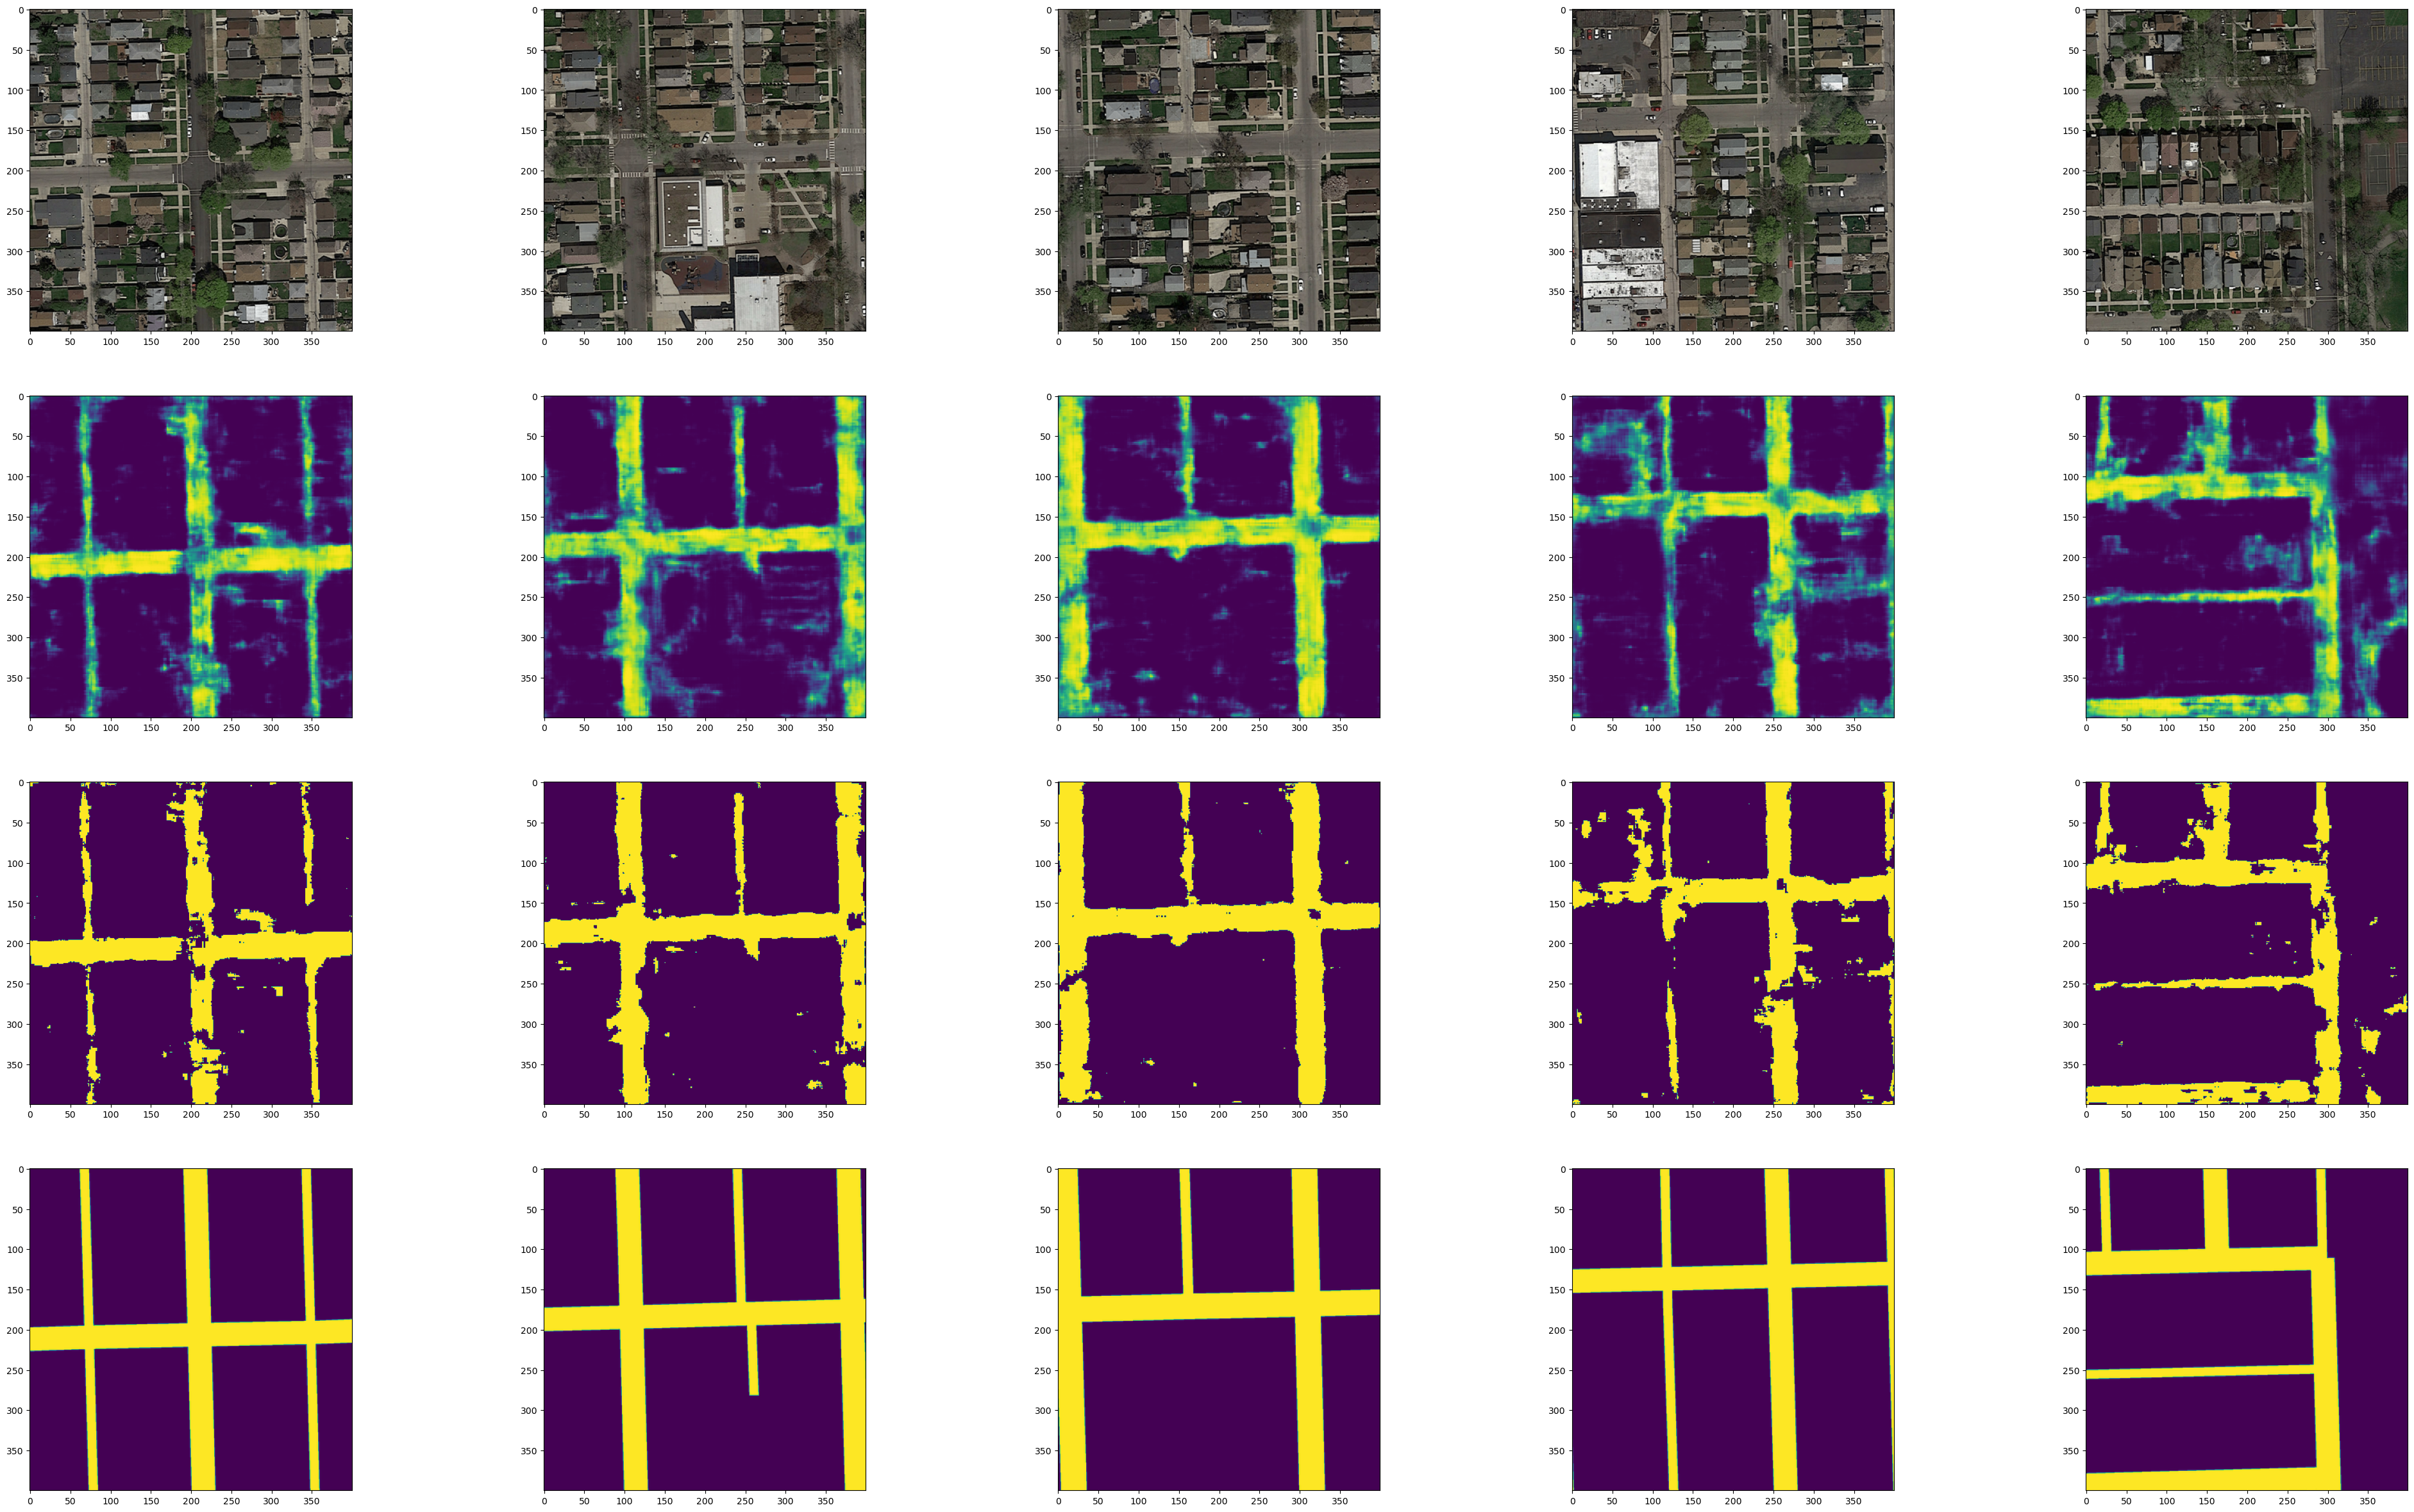

In [53]:
def visualize(model):
    model.eval()
    fig = plt.figure(figsize=(50, 30))
    with torch.no_grad():
        for i in range(5):
            img = imgs[i]
            gt_img = gt_imgs[i]
            img_patches = img_crop(img, PATCH_SIZE, PATCH_SIZE)
            gt_patches = img_crop(gt_img, PATCH_SIZE, PATCH_SIZE)
            inpp = img_patches[0]
            input_ = img_transform(inpp).to(device)
            output = model(input_).cpu().numpy().reshape((400, 400))
            input_ = input_.cpu().numpy()
            
            # from output generate
            fig.add_subplot(4, 5, 1+i)
            plt.imshow(inpp)
            fig.add_subplot(4, 5, 6+i)
            plt.imshow(output)
            
            fig.add_subplot(4, 5, 11+i)
            plt.imshow(output>.5)
            fig.add_subplot(4, 5, 16+i)
            plt.imshow(gt_patches[0])
    plt.show()


visualize(model)